<a href="https://colab.research.google.com/github/pejmanrasti/Computer-Vision/blob/main/Jour%202/EPU_4_ComparerPlusieursModeles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**5. Evaluer plusieurs modèles**


In [ ]:
import os
import warnings
import math

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import RandomizedSearchCV,RepeatedStratifiedKFold, StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, roc_auc_score,precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import  RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import arange
from numpy import mean
from numpy import std
from numpy import percentile

from matplotlib import pyplot as plt

from imblearn.under_sampling import RandomUnderSampler



# Import, séparation et rééchantillonnage des données


In [ ]:
df = read_csv("/content/DataSet_RegionPelvienne_Class.csv", sep = ",", header=0)
df = df.drop(columns = ["Unnamed: 0"])

y = df['Echec']
z = df.drop('Echec', axis = 1)

#On met de côté les données test qui seront utilisées à la fin
X_train, X_test, Y_train, Y_test = train_test_split(z,y, test_size = 0.3,stratify=y, random_state=2023)

#Rééchantillonnage
rus = RandomUnderSampler(sampling_strategy={
        0: len(Y_train[Y_train==1])*2,
        1: len(Y_train[Y_train==1])

    }, random_state=2023)
X_train_res, Y_train_res = rus.fit_resample(X_train, Y_train)

# Pour simplifier la suite on transforme les arrays de variables en dataframes
X_train_res = pd.DataFrame(X_train_res, columns = z.columns)
X_test = pd.DataFrame(X_test, columns = z.columns)



# Paramétrage des algorithmes

In [ ]:
# On définit un dictionnaire qui regroupe pour chaque algo : le pipeline et les hyper-paramètres à tester pendant la recherche sur grille
# Cette fois ci on utilise l'analyse en composantes principales pour réduire la dimension des variables. On demande de conserver 95% de la variance des données.
model_params = {



    'RF': {
            'model': Pipeline([('scale', StandardScaler()), ('pca', PCA(n_components=0.95)),
                               ('clf', RandomForestClassifier())]),
            'params': {
            'clf__n_estimators': [20, 50, 100, 150, 200],
            'clf__max_depth' : [None, 5, 10, 15, 20, 50],
            'clf__class_weight': [None, 'balanced', 'balanced_subsample']

        }
    },



     'SVC' : {
        'model' :  Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', SVC(probability = True))]) ,
        'params' : {
            'clf__C': [0.1, 0.2, 0.5, 1, 2],
            'clf__class_weight': [None, 'balanced']

        }
    },



    'LR': {
        'model': Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', LogisticRegression())]),
        'params': {
            'clf__C': [0.05, 0.1, 0.5, 0.8, 1, 2, 3, 10],
            'clf__class_weight': [None, 'balanced']


            }
    },



    'KNN': {
        'model':  Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', KNeighborsClassifier())]),
        'params':{
            'clf__n_neighbors' : [5, 6, 7],

        }
    },


    'QDA': {
        'model':  Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', QuadraticDiscriminantAnalysis())]),
        'params':{
            'clf__reg_param' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
            'clf__tol' : [1e-08, 1e-07, 1e-06, 1e-05, 1e-04]

        }
    },


}

# Paramétrage des métriques de performances

In [ ]:
# Définition des métriques que l'on souhaite utiliser lors de la CV
def AUC(clf, X, y_true):
  #Aire sous la courbe ROC
    y_pred_proba = clf.predict_proba(X)
    return  roc_auc_score(y_true, y_pred_proba[:, 1])

def AUPRC(clf, X, y_true):
  #Aire sous la courbe PR
    y_pred_proba = clf.predict_proba(X)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba[:, 1])
    auc_score = metrics.auc(recall, precision)
    return (auc_score)

# On crée un dictionnaire des métriques qu'on veut évaluer pour les paramètres de la CV :
metriques = {"AUPRC": AUPRC,
        "AUROC": AUC}

# Définition des métriques hors CV pour calculer AUROC et AUPRC sur les données test
def AUC(orig, proba):
    # ATTENTION : proba = probabilité prédite d'appartenir à la classe positive !
    # Si proba = classe prédite ==> BIAIS
    return  roc_auc_score(orig, proba[:, 1])
def AUPRC(orig, proba):
    precision, recall, _ = precision_recall_curve(orig, proba[:, 1])
    auc_score = metrics.auc(recall, precision)
    return (auc_score)

# Entrainement des modèles par défaut
On va entrainer les modèles avec les hyper-paramètres définis par défaut dans les algo scikit.

In [ ]:
%%time

# On définit sur quelle métrique on veut ajuster les modèles lors de la CV
# Si on ne calcule qu'une seule métrique lors de la CV, ce paramètre est inutile
refit = 'AUROC'

#On définit des arrays qui vont nous servir à stocker les résultats
names = []
AUPRCval, AUCval = [], []

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 5, random_state=2023)


for model_name, mp in model_params.items():
    print("> ", model_name)

    scores = cross_validate(mp['model'], X_train_res, Y_train_res, scoring=metriques,
                            cv=cv, n_jobs=-1, error_score='raise',return_train_score=False )

    AUCval= np.append(AUCval,scores['test_AUROC']*100 )
    AUPRCval= np.append(AUPRCval,scores['test_AUPRC']*100 )
    for i in range (0, len(scores['test_AUROC'])) :
        names.append(model_name)



>  RF
>  SVC
>  LR
>  KNN
>  QDA
CPU times: user 558 ms, sys: 69.3 ms, total: 627 ms
Wall time: 5.7 s


In [ ]:
# On stocke les résultats dans un dataframe
Scores = pd.DataFrame({'Algorithme' : names, 'AUROC' : AUCval, 'AUPRC' : AUPRCval})

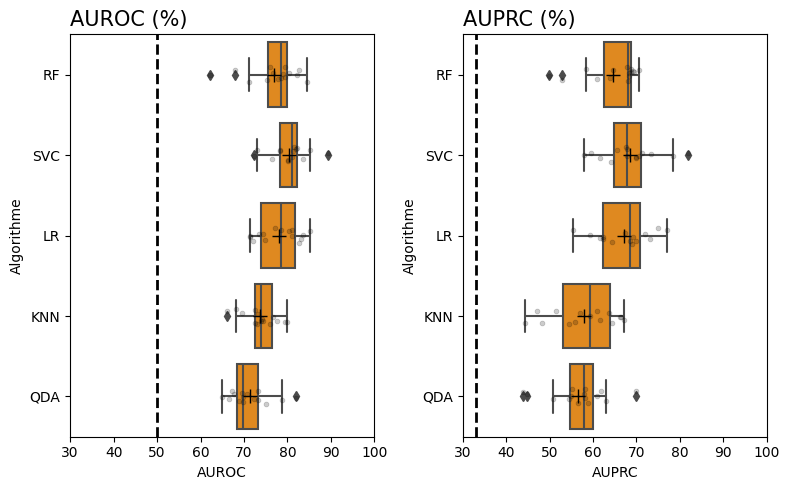

In [ ]:
# On peut utiliser la bibliothèque Seaborn qui est une sorte de surcouche de matplotlib pour faire des graphes plus jolis
import seaborn as sns

#On va afficher 2 figures, pour AUROC et AUPRC
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

#On sélectionne un style d'affichage défini dans les bibliothèques de seaborn
sns.set_style("whitegrid")

#Affichage boxplots
sns.boxplot(ax=axes[0],
            x ='AUROC',
            y = 'Algorithme',
            data = Scores,
            orient="h",
            color='darkorange',
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     }).set_title("AUROC (%)", fontdict={'size':15},loc='left')

#Pour ajouter les points en transparence dans les boxplots :
sns.stripplot(ax=axes[0],
              x ='AUROC',
            y = 'Algorithme',
            data = Scores,
              color = 'black',
              orient="h",
              size = 7,
               marker='.',
              linewidth = 0.5,
              alpha = 0.2)
#On peut ajouter une ligne verticale pour l'AUROC qui correspond à la valeur pour un modèle aléatoire
axes[0].axvline(x = 50, color = 'black', ls='--', lw=2)
axes[0].set_xlim([30, 100])


sns.boxplot(ax=axes[1],
            x ='AUPRC',
            y = 'Algorithme',
            data = Scores,
            orient="h",
            color='darkorange',
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     }).set_title("AUPRC (%)", fontdict={'size':15},loc='left')

sns.stripplot(ax=axes[1],
              x ='AUPRC',
            y = 'Algorithme',
            data = Scores,
              color = 'black',
              orient="h",
              size = 7,
               marker='.',
              linewidth = 0.5,
              alpha = 0.2)
axes[1].set_xlim([30, 100])
#On peut ajouter une ligne verticale pour l'AUPRC aussi, qui correspond à la performance d'un modèle non informatif = taux de positifs = 33% ici
axes[1].axvline(x = 33, color = 'black', ls='--', lw=2)


fig.tight_layout()




---



---



**6. Réglage fin des modèles**

# Ajustement des hyper-paramètres des modèles
Maintenant, on va réaliser une recherche sur grille pour les hyper-paramètres définis dans le dictionnaire model_params.

In [ ]:
%%time

# On définit sur quelle métrique on veut ajuster les modèles lors de la CV
# Si on ne calcule qu'une seule métrique lors de la CV, ce paramètre est inutile
refit = 'AUROC'

#On définit des arrays qui vont nous servir à stocker les résultats
names = []
AUPRCval, AUCval = [], []


cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 5, random_state=2023)
for model_name, mp in model_params.items():
    print("> ", model_name)
    clf = GridSearchCV(mp['model'],
                        mp['params'],
                        cv=cv,
                        return_train_score=False,
                        scoring=metriques,
                        refit = refit,
                        error_score="raise",
                        n_jobs=-1)

    clf.fit(X_train_res, Y_train_res)
    results = clf.cv_results_
    best_index = np.nonzero(results["rank_test_AUROC"] == 1)[0][0]

    # Au lieu de récupérer la valeur moyenne sur tous les folds de validation pour le set d'hyper-paramètres choisi,
    # on récupère la valeur obtenue sur chaque fold de validation pour avoir la dispersion sous forme de boxplot et comparer avec les résultats précédents
    # On boucle sur 15 folds car on demande une CV de 3 folds répétées 5x
    for i in range (0, 15):
      AUCval= np.append(AUCval,results['split%s_test_AUROC'%i][best_index]*100 )
      AUPRCval= np.append(AUPRCval,results['split%s_test_AUPRC'%i][best_index]*100 )
      names.append(model_name)


>  RF
>  SVC
>  LR
>  KNN
>  QDA
CPU times: user 14.1 s, sys: 1.07 s, total: 15.2 s
Wall time: 5min 8s


In [ ]:
# On stocke les résultats dans un dataframe
Scores_ajust = pd.DataFrame({'Algorithme' : names, 'AUROC' : AUCval, 'AUPRC' : AUPRCval})

In [ ]:
# On fusionne les deux dataframe
Hyperparam = np.concatenate((np.repeat("Defaut", len(Scores.Algorithme)), np.repeat("Ajustés", len(Scores_ajust.Algorithme))))
Scores_tot = pd.concat([Scores, Scores_ajust])
Scores_tot["Hyper-paramètres"] = Hyperparam
Scores_tot.head()

,Algorithme,AUROC,AUPRC,Hyper-paramètres
0,RF,79.411765,68.299600,Defaut
1,RF,75.298380,60.952105,Defaut
2,RF,82.731092,70.598331,Defaut
3,RF,79.518329,64.659156,Defaut
4,RF,84.612106,68.316434,Defaut


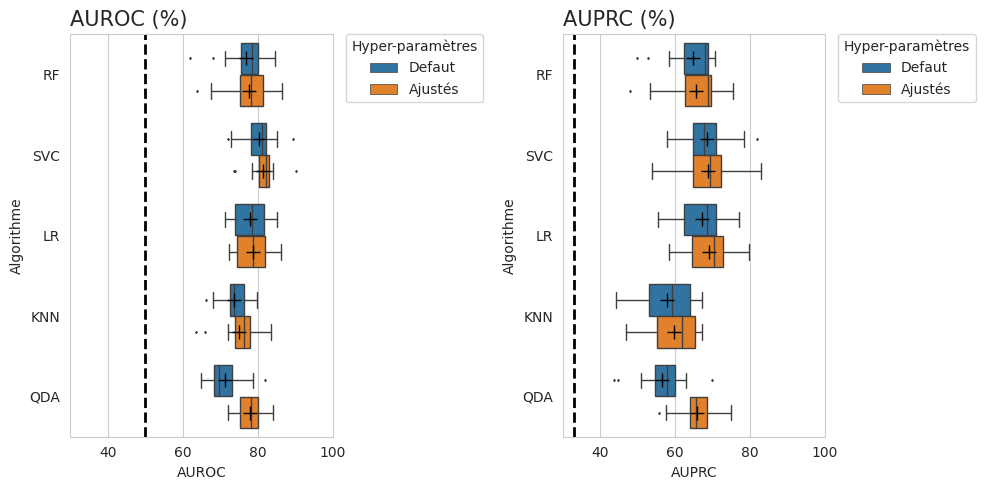

In [ ]:
# On peut utiliser la bibliothèque Seaborn qui est une sorte de surcouche de matplotlib pour faire des graphes plus jolis
import seaborn as sns

#On va afficher 2 figures, pour AUROC et AUPRC
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

#On sélectionne un style d'affichage défini dans les bibliothèques de seaborn
sns.set_style("whitegrid")

#Affichage boxplots
sns.boxplot(ax=axes[0],
            x ='AUROC',
            y = 'Algorithme',
            data = Scores_tot,
            hue = 'Hyper-paramètres', # On rajoute le paramètre hue qui va permettre de faire automatiquement la distinction entre les données par défaut et ajustées
            orient="h",
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     },
            fliersize = 1,
            linewidth = 1).set_title("AUROC (%)", fontdict={'size':15},loc='left')
#On peut ajouter une ligne verticale pour l'AUROC qui correspond à la valeur pour un modèle aléatoire
axes[0].axvline(x = 50, color = 'black', ls='--', lw=2)
axes[0].set_xlim([30, 100])
axes[0].legend(title = 'Hyper-paramètres', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.boxplot(ax=axes[1],
            x ='AUPRC',
           y = 'Algorithme',
            data = Scores_tot,
            hue = 'Hyper-paramètres',
            orient="h",
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     },
            fliersize = 1,
            linewidth = 1).set_title("AUPRC (%)", fontdict={'size':15},loc='left')

axes[1].set_xlim([30, 100])
axes[1].legend(title = 'Hyper-paramètres', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#On peut ajouter une ligne verticale pour l'AUPRC aussi, qui correspond à la performance d'un modèle non informatif = taux de positifs = 33% ici
axes[1].axvline(x = 33, color = 'black', ls='--', lw=2)

fig.tight_layout()


# Méthodes ensemblistes
* Il existe 4 principales méthodes ensemblistes : le bagging, le boosting, le voting et le stacking
* Ces méthodes reposent sur un ensemble de modèles "faibles" (aux performances individuelles médiocres) mais qui, combinés, permettent d'obtenir des prédictions robustes avec une variance réduite.
* **Bagging** : on entraine un même algorithme sur plusieurs sous-ensembles des données d'entrainement, tirés aléatoirement. Chaque modèle est entrainé sur une petite partie des données et fourni donc des prédictions plus biaisées qu'un modèle qui aurait été entrainé sur la totalité des données. Cependant, en combinant les prédictions de chacun de ces modèles on peut parvenir à obtenir un biais équivalent à un modèle unique entrainé sur la totalité des données mais avec une variance plus faible. Les forêts aléatoires reposent sur le principe du bagging utilisé avec l'algorithme arbre de décision.
* **Boosting** : on entraine un algorithme en séquentiel sur l'ensemble des données. A chaque itération, les performances du classifieur issu du prédécent entrainement sont corrigées pour entrainer le prochain classifieur. Il existe différentes méthodes pour appliquer des corrections (par exemple : modification du poids des observations pour l'adaptative boosting ou ajustement sur l'erreur résiduelle en gradient boosting)
* **Voting** : cette méthode repose sur la combinaison de plusieurs algorithmes différents. Chaque algorithme est entrainé sur la totalité des donnés d'entrainement. La prédiction finale est obtenue de deux manières : hard voting (le vote rigide : la classe avec le plus grand nombre de votes est choisie) ou soft voting (vote souple : la classe avec la probabilité prédite moyenne la plus grande est choisie). Le vote souple est souvent préféré car plus de poids est accordé aux votes dont la probabilité est forte. Utiliser une diversité d'algorithmes permet d'augmenter les chances d'obtenir des erreurs différentes et donc de potentialiser l'intérêt de combiner les différentes prédictions.
* **Stacking** : Même principe que le voting, mais au lieu d'utiliser le vote pour réaliser la prédiction finale, on entraine un algorithme pour apprendre à combiner les prédictions des classifieurs de base. On peut réaliser un empilement de classifieurs : la 1ère couche est entrainée sur les données d'entrainemenent, la 2ème couche est entrainée sur un jeux de données constitué des prédictions de la 1ère couche, etc etc.
* **Sélection des algorithmes pour le voting et le stacking** : tout comme pour la sélection variables, il peut être intéressant de réaliser une sélection des meilleurs algorithmes à combiner dans une méthode ensembliste variée. Pour cela, on peut utiliser des méthodes analogues au RFE. La méthode du **pruning** (ou élagage) implique de supprimer un algorithme de l'ensemble, de réévaluer les performances de la méthode d'ensemble et de répéter cela pour chaque membre de l'ensemble. Si de meilleures performances sont obtenues après avoir supprimer un membre de l'ensemble, alors ce dernier est définitivement supprimé de l'ensemble et la procédure de suppression itérative est poursuivie jusqu'à ce qu'aucune amélioration des performances ne soit plus obtenue. La méthode du **growing** (ou croissance) commence au contraire avec un seul algorithme, celui de l'ensemble qui a les meilleures performances, et ajoute au fur et à mesure les algorithmes de l'ensemble.

In [ ]:
%%time

# Exemple : Méthode de stacking simple à 2 couches

# On définit les classifieurs de base
stacking_clf = [('RF', Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', RandomForestClassifier(criterion = 'gini', max_features = 'sqrt', class_weight = 'balanced'))])),
              ('LR', Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf',LogisticRegression(solver ='lbfgs', class_weight = 'balanced'))])),
              ('KNN', Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf',KNeighborsClassifier(weights = 'distance'))])),
              ('SVC', Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf', SVC(probability = True, max_iter=10000, kernel = 'linear', class_weight = 'balanced'))])),
              ('QDA',  Pipeline([('scale', StandardScaler()),('pca', PCA(n_components=0.95)),
                               ('clf',QuadraticDiscriminantAnalysis())])),
             ]

# On définit les paramètres à tester pour chaque classifieurs
stacking_params = {
            'RF__clf__n_estimators': [100, 150],
            'RF__clf__max_depth' : [6, 8, 10, 12],

            'SVC__clf__C': [0.1, 0.2, 0.5],

            'LR__clf__C': [0.05, 0.1, 0.5, 0.8, 1],

            'KNN__clf__n_neighbors': [4, 5, 6],

            'QDA__clf__reg_param' : [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
            'QDA__clf__tol' : [1e-08, 1e-07, 1e-06, 1e-05, 1e-04],

            'final_estimator__C': [0.5, 0.8, 1, 5, 10]


         }



# On définit la cv de la recherche sur grille pour les hyper-paramètres
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 5, random_state=2023)

# CV pour le méta-classifieur (classifieur qui combinent les prédictions de classifieurs de la 1ère couche)
meta_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=2023)

# Méta-classifieur. Il combine les prédictions des classifieurs de base en utilisant une régression logistique
meta_model = StackingClassifier(estimators= stacking_clf , # 1ère couche : les classifieurs qui sont entrainés sur le jeu de données
                                final_estimator= LogisticRegression(), # 2ème couche : l'algo qui combine les prédictions des classifieurs de la 1ère couche
                                cv= meta_cv)

# On réalise une recherche randomisée pour éviter que la recherche sur grille soit indéfiniment longue
# En effet, ce n'est pas chaque combinaison d'hyper-paramètres pour chaque algo pris indépendamment qui est testée
# mais toutes les combinaisons d'hyper-paramètres pour toutes les combinaisons d'algo possibles.
clf = RandomizedSearchCV (estimator=meta_model,
                        param_distributions=stacking_params,
                        n_iter = 10,
                        return_train_score=False,
                       scoring=metriques,
                          refit = 'AUROC',
                        cv=cv,
                        n_jobs=-1,
                        random_state = 2023)

clf.fit(X_train_res, Y_train_res)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


CPU times: user 4.64 s, sys: 1.31 s, total: 5.95 s
Wall time: 2min 52s


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=3, random_state=2023),
                   estimator=StackingClassifier(cv=StratifiedKFold(n_splits=3, random_state=2023, shuffle=True),
                                                estimators=[('RF',
                                                             Pipeline(steps=[('scale',
                                                                              StandardScaler()),
                                                                             ('pca',
                                                                              PCA(n_components=0.95)),
                                                                             ('clf',
                                                                              RandomForestClassifier(class_weight='balanced'))])),
                                                            ('LR',
                                                             Pipeline(steps...
                                        'QDA__clf__reg_param': [0.0, 0.1, 0.2,
                                                                0.3, 0.4, 0.5,
                                                                0.6, 0.7],
                                        'QDA__clf__tol': [1e-08, 1e-07, 1e-06,
                                                          1e-05, 0.0001],
                                        'RF__clf__max_depth': [6, 8, 10, 12],
                                        'RF__clf__n_estimators': [100, 150],
                                        'SVC__clf__C': [0.1, 0.2, 0.5],
                                        'final_estimator__C': [0.5, 0.8, 1, 5,
                                                               10]},
                   random_state=2023, refit='AUROC',
                   scoring={'AUPRC': <function AUPRC at 0x7e71dfb36e60>,
                            'AUROC': <function AUC at 0x7e721badf0a0>})

In [ ]:
results = clf.cv_results_
best_index = np.nonzero(results["rank_test_AUROC"] == 1)[0][0]

AUCval = []
AUPRCval = []
names = []
# Au lieu de récupérer la valeur moyenne sur tous les folds de validation pour le set d'hyper-paramètres choisi,
# on récupère la valeur obtenue sur chaque fold de validation pour avoir la dispersion sous forme de boxplot et comparer avec les résultats précédents
# On boucle sur 15 folds car on demande une CV de 3 folds répétées 5x
for i in range (0, 15):
  AUCval= np.append(AUCval,results['split%s_test_AUROC'%i][best_index]*100 )
  AUPRCval= np.append(AUPRCval,results['split%s_test_AUPRC'%i][best_index]*100 )
  names.append("metamodel")


# On crée un DataFrame
Scores_meta = pd.DataFrame({'Algorithme' : names, 'AUROC' : AUCval, 'AUPRC' : AUPRCval})

In [ ]:
# On fusionne avec les résultats précédents :
Scores_all = pd.concat([Scores_ajust, Scores_meta])

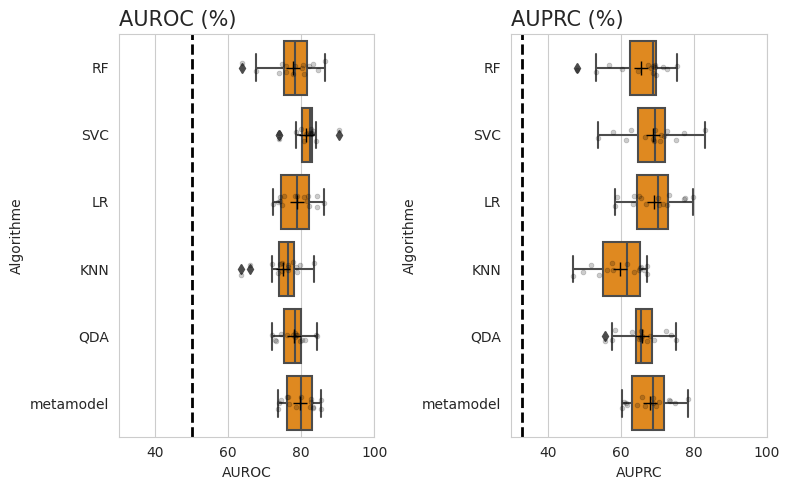

In [ ]:
# On peut utiliser la bibliothèque Seaborn qui est une sorte de surcouche de matplotlib pour faire des graphes plus jolis
import seaborn as sns

#On va afficher 2 figures, pour AUROC et AUPRC
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,5))

#On sélectionne un style d'affichage défini dans les bibliothèques de seaborn
sns.set_style("whitegrid")

#Affichage boxplots
sns.boxplot(ax=axes[0],
            x ='AUROC',
            y = 'Algorithme',
            data = Scores_all,
            orient="h",
            color='darkorange',
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     }).set_title("AUROC (%)", fontdict={'size':15},loc='left')

#Pour ajouter les points en transparence dans les boxplots :
sns.stripplot(ax=axes[0],
              x ='AUROC',
            y = 'Algorithme',
            data = Scores_all,
              color = 'black',
              orient="h",
              size = 7,
               marker='.',
              linewidth = 0.5,
              alpha = 0.2)
#On peut ajouter une ligne verticale pour l'AUROC qui correspond à la valeur pour un modèle aléatoire
axes[0].axvline(x = 50, color = 'black', ls='--', lw=2)
axes[0].set_xlim([30, 100])


sns.boxplot(ax=axes[1],
            x ='AUPRC',
            y = 'Algorithme',
            data = Scores_all,
            orient="h",
            color='darkorange',
            showmeans=True,
            meanprops={"marker":"+",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10",
                     }).set_title("AUPRC (%)", fontdict={'size':15},loc='left')

sns.stripplot(ax=axes[1],
              x ='AUPRC',
            y = 'Algorithme',
            data = Scores_all,
              color = 'black',
              orient="h",
              size = 7,
               marker='.',
              linewidth = 0.5,
              alpha = 0.2)
axes[1].set_xlim([30, 100])
#On peut ajouter une ligne verticale pour l'AUPRC aussi, qui correspond à la performance d'un modèle non informatif = taux de positifs = 33% ici
axes[1].axvline(x = 33, color = 'black', ls='--', lw=2)


fig.tight_layout()


*Pour aller plus loin : tester d'autres algorithmes pour le méta-classifieur et tester le vote simple et le vote souple avec la fonction VotingClassifier de scikit*

# Sélection et évaluation du modèle final

In [ ]:
%%time

# Si on décide que le SVM est le plus adapté

refit = 'AUROC'

#On définit des arrays qui vont nous servir à stocker les résultats
names = []
AUPRCval, AUCval = [], []

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats = 5, random_state=2023)


for model_name, mp in model_params.items():
    if model_name == "SVC":
      print("> ", model_name)
      clf = GridSearchCV(mp['model'],
                          mp['params'],
                          cv=cv,
                          return_train_score=False,
                          scoring=metriques,
                          refit = refit,
                          error_score="raise",
                          n_jobs=-1)

      clf.fit(X_train_res, Y_train_res)
      results = clf.cv_results_
      best_index = np.nonzero(results["rank_test_AUROC"] == 1)[0][0]
      model_final =  mp['model'].set_params(**results["params"][best_index]).fit(X_train_res, Y_train_res)



>  SVC
CPU times: user 604 ms, sys: 179 ms, total: 783 ms
Wall time: 10.4 s


In [ ]:
#Prédictions sur les données d'entrainement
Y_train_proba = model_final.predict_proba(X_train_res)

#Prédictions des données test
Y_test_proba = model_final.predict_proba(X_test)


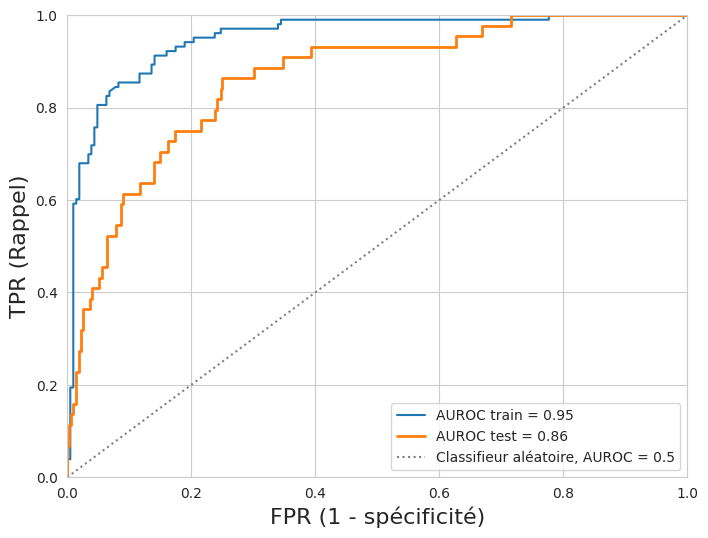

In [ ]:
# Evaluation des données test
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], linestyle='dotted', color = 'grey', label = 'Classifieur aléatoire, AUROC = 0.5')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('FPR (1 - spécificité)', fontsize=16)
    plt.ylabel('TPR (Rappel)', fontsize=16)
    plt.grid(True)

# Attention pour calculer la courbe ROC il faut toujours utiliser les probabilités et non les classes prédites.
# Ici on s'intéresse à la classe 1 donc on utilise les probabilités de la seconde colonne de Y_proba_LR
auc_test = round(roc_auc_score(Y_test, Y_test_proba[:, 1]), 2)
auc_train = round(roc_auc_score(Y_train_res, Y_train_proba[:, 1]), 2)
fpr_test, tpr_test, thresholds_test = roc_curve(Y_test, Y_test_proba[:, 1])
fpr_train, tpr_train, thresholds_train = roc_curve(Y_train_res, Y_train_proba[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label = "AUROC train = " + str(auc_train))
plot_roc_curve(fpr_test, tpr_test, label = "AUROC test = " + str(auc_test))
plt.legend(loc = 'lower right')
plt.show()

> On s'attend à ce que les performances du modèle soit bien supérieures sur les données d'entrainement puisqu'il les a déjà vues pendant l'entrainement.

> Pour estimer l'**erreur de généralisation**, il faut comparer les performances sur les données test avec les performances obtenues sur les folds de validation lors de la CV.

> L'estimation de l'erreur de généralisation est une étape importante car elle permet de s'assurer que le modèle n'est pas sur-ajusté sur les données d'entrainement.

In [ ]:
# Comparaison des AUROC entre validation et test
print("AUROC validation = ", round(results['mean_test_AUROC'][best_index]*100, 1), "% +-", round(results['std_test_AUROC'][best_index]*100, 1), "%")
print("AUROC test = ", auc_test*100, "%")

AUROC validation =  81.0 % +- 4.0 %
AUROC test =  86.0 %


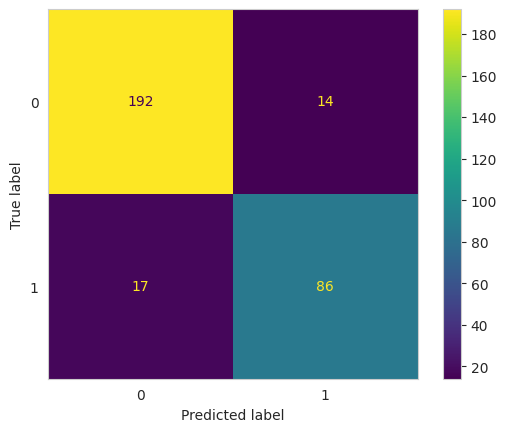

In [ ]:
# Résultats prédits en fonction du seuil de décision sur les données d'entrainement
seuil = 0.5
y_train_pred = np.where(Y_train_proba[:, 1] > seuil, 1, 0)

cm = confusion_matrix(Y_train_res, y_train_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = [0,1])
cm_display.plot()
plt.grid(False)
plt.show()

In [ ]:
# calcul de la sensibilité (ou rappel) à partir du tableau de la matrice de confusion cm[ligne][colonne]
FN = cm[1][0]
TP = cm[1][1]
TPR = TP/(TP+FN)*100
print("Le modèle détecte %0.0f%% des échecs." %TPR)

Le modèle détecte 83% des échecs.


In [ ]:
# calcul de la spécificité
TN = cm[0][0]
FP = cm[0][1]
TNR = TN/(FP+TN)*100
print("Le modèle détecte %0.0f%% des réussites." %TNR)

Le modèle détecte 93% des réussites.


In [ ]:
# calcul de la précision
TP = cm[1][1]
FP = cm[0][1]
# PPV pour predicted positive values
PPV = TP / (TP + FP)*100
print("Parmis les échecs détectés, %0.0f%% sont corrects." %PPV)

Parmis les échecs détectés, 86% sont corrects.


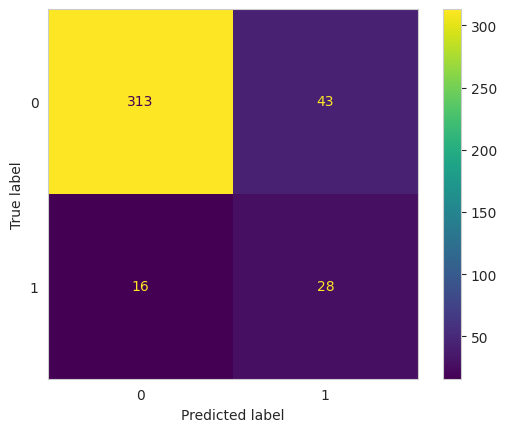

In [ ]:
# Résultats prédits en fonction du seuil de décision sur les données test
y_test_pred = np.where(Y_test_proba[:, 1] > seuil, 1, 0)

cm = confusion_matrix(Y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels = [0,1])
cm_display.plot()
plt.grid(False)
plt.show()

Pour aller plus loin
* Evaluer l'impact sur les résultats de la méthode de sélection des variables
* Comparer les performances avec et sans normalisation des données
* Evaluer d'autres algorithmes https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
